In [4]:
import pickle
fileObject = open("./data/preprocessing",'r')  
df_tablet = pickle.load(fileObject)  

In [5]:
df_X = df_tablet[[ 
        'word', 'sentence', 'flesch reading', 'word/sentence', 'syllable', 'display', 'sound', 'os', 'security', 'hardware', 'battery', 'bug', 'price', 'cs', 'wifi', 'accesory', 'app', 'compatible', 'depth', 'depth/word', 'usable', 'total topic', 'redundancy', 'redundancy/sentence', 'rank', 'pos topic', 'neg topic', 'density'
    ]]
df_y = df_tablet[['help class']]

In [6]:
from sklearn.cross_validation import train_test_split

X = df_X.as_matrix(columns=None)
y = np.ravel(df_y.values)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)

# RandomForest Parameter Tuning
=================================================================================================================
* Find optimal parameters through grid search and compare them with those obtained by greedy method
* Among numerous scoring types such as recall, accuracy, precision, f1 score, etc, this project will focus on recall-related scores.
* This is because, I believe, high 'true positive rate (tpr)' can be the clue to solve the problem I defined in this project

In [9]:
# baseline confirmation, implying that model has to perform at least as good as it
from sklearn.dummy import DummyClassifier 
clf_Dummy = DummyClassifier(strategy='most_frequent')
clf_Dummy = clf_Dummy.fit(X_train, y_train)
print('baseline score =>', round(clf_Dummy.score(X_test, y_test), 2))

baseline score => 0.51


===================================================================================================================

### 1. Find optimal parameter

#### 1) Greedy Method  (sequential parameter tuning)

* good point of  sequential parameter tuing is that I can see the how certain parameter affects the performance.
* ...however, I found this not very useful when finding the optimal combination of parameters.
* ...so using this method after grid search would be fast and nice

(1) n_estimators

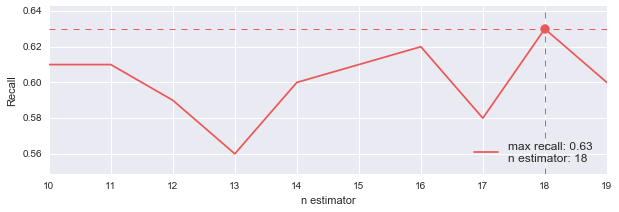

In [506]:
from sklearn.metrics import recall_score
from sklearn.ensemble import RandomForestClassifier
from matplotlib.pyplot import axvline, axhline

recall_range = []
n_estimator_range = []

for i in np.arange(10, 20, 1):
    clf_RF = RandomForestClassifier(oob_score=True, n_estimators=i).fit(X_train, y_train)
    clf_RF_predicted = clf_RF.predict(X_test)
    recall = round(recall_score(clf_RF_predicted, y_test), 2)
    
    n_estimator_range.append(i)
    recall_range.append(recall)
    dictionary = dict(zip(n_estimator_range, recall_range))
    
plt.figure(figsize=(10, 3))
plt.plot(n_estimator_range, recall_range, color='#EA5959', label='max recall: %(n)0.2f \n%(s)s: %(v)2d' %  
         {'n':max(dictionary.values()), 's':'n estimator', 'v':max(dictionary, key=lambda i: dictionary[i])})
plt.scatter([max(dictionary, key=lambda i: dictionary[i]), ], [max(dictionary.values()), ], 80, color='#EA5959')
axhline(max(dictionary.values()), color='#EA5959', linewidth=1, linestyle='--')
axvline(max(dictionary, key=lambda i: dictionary[i]), color='#EA5959', linewidth=1, linestyle='--')
plt.legend(loc='lower right', prop={'size':12}) 
plt.xlim(min(n_estimator_range), max(n_estimator_range))
plt.ylim(min(recall_range)*0.98, max(recall_range)*1.02)
plt.ylabel('Recall')
plt.xlabel('n estimator');

(2) max features

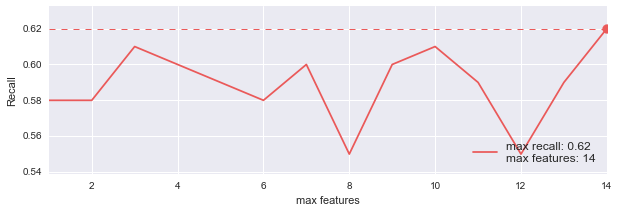

In [511]:
recall_range = []
max_features_range = []

for i in np.arange(1, 15, 1):
    clf_RF = RandomForestClassifier(oob_score=True, n_estimators=18, max_features=i).fit(X_train, y_train)
    clf_RF_predicted = clf_RF.predict(X_test)
    recall = round(recall_score(clf_RF_predicted, y_test), 2)
    
    max_features_range.append(i)
    recall_range.append(recall)
    dictionary = dict(zip(max_features_range, recall_range))
    
plt.figure(figsize=(10, 3))
plt.plot(max_features_range, recall_range, color='#EA5959', label='max recall: %(n)0.2f \n%(s)s: %(v)2d' %  
         {'n':max(dictionary.values()), 's':'max features', 'v':max(dictionary, key=lambda i: dictionary[i])})
plt.scatter([max(dictionary, key=lambda i: dictionary[i]), ], [max(dictionary.values()), ], 80, color='#EA5959')
axhline(max(dictionary.values()), color='#EA5959', linewidth=1, linestyle='--')
axvline(max(dictionary, key=lambda i: dictionary[i]), color='#EA5959', linewidth=1, linestyle='--')
plt.legend(loc='lower right', prop={'size':12}) 
plt.xlim(min(max_features_range), max(max_features_range))
plt.ylim(min(recall_range)*0.98, max(recall_range)*1.02)
plt.ylabel('Recall')
plt.xlabel('max features');

(3) min sample leaf

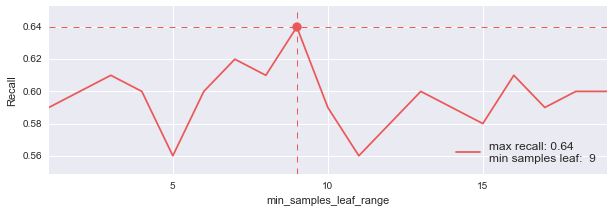

In [513]:
recall_range = []
min_samples_leaf_range = []

for i in np.arange(1, 20, 1):
    clf_RF = RandomForestClassifier(oob_score=True, n_estimators=18, max_features=14, min_samples_leaf=i).fit(X_train, y_train)
    clf_RF_predicted = clf_RF.predict(X_test)
    recall = round(recall_score(clf_RF_predicted, y_test), 2)
    
    min_samples_leaf_range.append(i)
    recall_range.append(recall)
    dictionary = dict(zip(min_samples_leaf_range, recall_range))
    
plt.figure(figsize=(10, 3))
plt.plot(min_samples_leaf_range, recall_range, color='#EA5959', label='max recall: %(n)0.2f \n%(s)s: %(v)2d' %  
         {'n':max(dictionary.values()), 's':'min samples leaf', 'v':max(dictionary, key=lambda i: dictionary[i])})
plt.scatter([max(dictionary, key=lambda i: dictionary[i]), ], [max(dictionary.values()), ], 80, color='#EA5959')
axhline(max(dictionary.values()), color='#EA5959', linewidth=1, linestyle='--')
axvline(max(dictionary, key=lambda i: dictionary[i]), color='#EA5959', linewidth=1, linestyle='--')
plt.legend(loc='lower right', prop={'size':12}) 
plt.xlim(min(min_samples_leaf_range), max(min_samples_leaf_range))
plt.ylim(min(recall_range)*0.98, max(recall_range)*1.02)
plt.ylabel('Recall')
plt.xlabel('min_samples_leaf_range');

#### 2) Grid Search
* very efficient way to find optimal parameter values
* assigning 'appropriate' value range seems essential in grid search. For instance, I set the value range for 'max_features' to 10 to 28, since I wanted the model to be robust, at the expense of performance to some extent.

In [32]:
from sklearn.pipeline import Pipeline
pipeline_clf_train = Pipeline(
    steps=[
        ('clf_RF', RandomForestClassifier()),
    ]
);

In [34]:
from sklearn.grid_search import GridSearchCV
parameters = {
    'clf_RF__min_samples_leaf' : np.arange(1, 28, 1),
    'clf_RF__max_features' : np.arange(10, 28, 1),
    'clf_RF__criterion' :['gini', 'entropy'],
    'clf_RF__n_estimators' : [10],
    #'clf_RF__oob_score' : ['True]
}
gs_clf = GridSearchCV(pipeline_clf_train, parameters, n_jobs=-1, scoring='recall')
gs_clf = gs_clf.fit(X_train, y_train)

In [35]:
best_parameters, score, _ = max(gs_clf.grid_scores_, key=lambda x: x[1])
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))
print('------------------------------')
print('recall score :', score.round(2))

clf_RF__criterion: 'entropy'
clf_RF__max_features: 19
clf_RF__min_samples_leaf: 27
clf_RF__n_estimators: 10
------------------------------
recall score : 0.77


### 2. Take a look at confusion matrix ([what is confusion matrix?](https://en.wikipedia.org/wiki/Confusion_matrix))

#### 1) Greedy method
* focal point of confusion matrix in this project is 'helpful' + 'recall'
* with parameters obtained from greed method, I got 0.68/1.0 meaning that out of 129 'helpful reviews' I predicted 88 reviews correctly.

In [531]:
clf_RF = RandomForestClassifier(n_estimators=18, max_features=14, min_samples_leaf=9, oob_score=True).fit(X_train, y_train)
clf_RF_predicted = clf_RF.predict(X_test)

In [532]:
from sklearn.metrics import classification_report, confusion_matrix
target_names = ['not helpful', 'helpful']
print(classification_report(y_test, clf_RF_predicted, target_names=target_names))

             precision    recall  f1-score   support

not helpful       0.63      0.56      0.59       123
    helpful       0.62      0.68      0.65       129

avg / total       0.62      0.62      0.62       252



[[69 54]
 [41 88]]


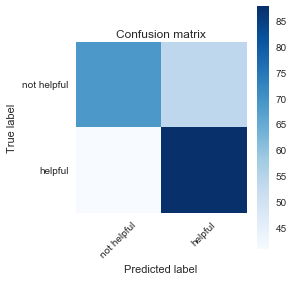

In [533]:
plt.figure(figsize=(4,4))
cm = confusion_matrix(y_test, clf_RF_predicted)
print(cm)
target_names = ['not helpful', 'helpful']
plt.grid(False)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(target_names))
plt.xticks(tick_marks, target_names, rotation=45)
plt.yticks(tick_marks, target_names)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label');

#### 2) Grid Search

* compared to the above, performance is better (0.75/1.0)

In [ ]:
clf_RF = RandomForestClassifier(n_estimators=10, max_features=19, min_samples_leaf=27, criterion='entropy', oob_score=True).fit(X_train, y_train)
clf_RF_predicted = clf_RF.predict(X_test)

In [338]:
from sklearn.metrics import classification_report, confusion_matrix
target_names = ['not helpful', 'helpful']
print(classification_report(y_test, clf_RF_predicted, target_names=target_names))

             precision    recall  f1-score   support

not helpful       0.67      0.52      0.58       123
    helpful       0.62      0.75      0.68       129

avg / total       0.64      0.64      0.63       252



[[64 59]
 [33 96]]


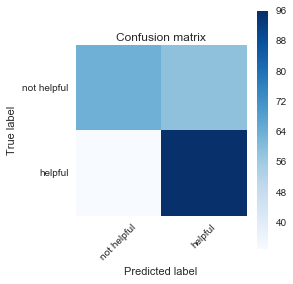

In [359]:
plt.figure(figsize=(4, 4))
cm = confusion_matrix(y_test, clf_RF_predicted)
print(cm)
target_names = ['not helpful', 'helpful']
plt.grid(False)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(target_names))
plt.xticks(tick_marks, target_names, rotation=45)
plt.yticks(tick_marks, target_names)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label');

### 3. ROC Curve ([what is ROC/AUC?](https://en.wikipedia.org/wiki/Receiver_operating_characteristic))

* Area Under the Curve (AUC) over 0.7 is considered useful in classification performance. 
    * (Streiner and Cairney, 2007, What's under the roc? an introduction to receiver operating charcteristics curves.)
* AUC calculated by grid search(0.68) is greater than that by greedy method(0.66) 

#### 1) Greedy Method

In [540]:
clf_RF = RandomForestClassifier(n_estimators=18, max_features=14, min_samples_leaf=9, oob_score=True).fit(X_train, y_train)
clf_RF_predicted = clf_RF.predict(X_test)

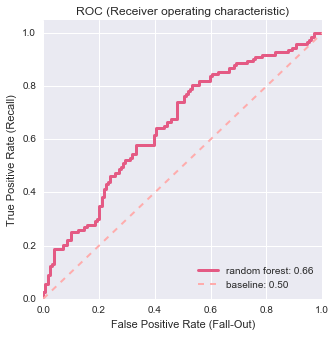

In [541]:
from sklearn.metrics import roc_curve, auc
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, clf_RF.predict_proba(X_test)[:, 0], pos_label=0)
fpr_base, tpr_base, thresholds_base = roc_curve(y_test,clf_Dummy.predict_proba(X_test)[:, 0], pos_label=1)

plt.figure(figsize=(5, 5))
plt.plot(fpr_rf, tpr_rf, color='#E45A84', linewidth=3, linestyle='-', 
         label = 'random forest: %(performance)0.2f' % {'performance':auc(fpr_rf, tpr_rf)})
plt.plot(fpr_base, tpr_base, color='#FFACAC', linewidth=2, linestyle='--', 
         label = 'baseline: %(performance)0.2f' % {'performance':auc(fpr_base, tpr_base)})
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC (Receiver operating characteristic)', fontdict={'fontsize': 12})
plt.legend(loc="lower right");

#### 2) Grid Search

In [318]:
clf_RF = RandomForestClassifier(n_estimators=10, max_features=19, min_samples_leaf=27, criterion='entropy', oob_score=True).fit(X_train, y_train)
clf_RF_predicted = clf_RF.predict(X_test)

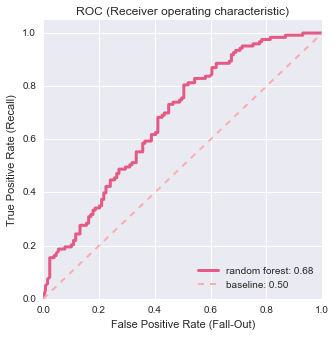

In [317]:
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, clf_RF.predict_proba(X_test)[:, 0], pos_label=0)
fpr_base, tpr_base, thresholds_base = roc_curve(y_test,clf_Dummy.predict_proba(X_test)[:, 0], pos_label=1)

plt.figure(figsize=(5, 5))
plt.plot(fpr_rf, tpr_rf, color='#E45A84', linewidth=3, linestyle='-', 
         label = 'random forest: %(performance)0.2f' % {'performance':auc(fpr_rf, tpr_rf)})
plt.plot(fpr_base, tpr_base, color='#FFACAC', linewidth=2, linestyle='--', 
         label = 'baseline: %(performance)0.2f' % {'performance':auc(fpr_base, tpr_base)})
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC (Receiver operating characteristic)', fontdict={'fontsize': 12})
plt.legend(loc="lower right");

### 4. So what?

* In this analysis, I tried to find optimal parameters for the model with greedy method and grid search.
* After checking several points, parameters of grid search turned out to outperform greedy method.

| | Greedy Method| <span style="color:#F64E8B; font-family:Georgia; font-size:12;"> Grid Search </span>  | 
| ------ ||| -------:| 
| TPR | 0.68 | <span style="color:#F64E8B; font-family:Georgia; font-size:12;"> 0.75 </span> |
| AUC | 0.66 | <span style="color:#F64E8B; font-family:Georgia; font-size:12;"> 0.68  </span> |